<h2>Isolation Forest for anomaly detection</h2>

In [1]:
#import necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.ensemble import IsolationForest

In [3]:
# import dataset 
from ucimlrepo import fetch_ucirepo

<p>We load our data directly from the UCI machine learning repository. We are using the Air Quality dataset (CC BY 4.0), which contains 9,358 instances of air quality measurements from a sensor in an Italian city. In the context of this dataset, an anomaly can be considered a sensor reading that indicates unusually high levels of pollution.</p>

In [9]:
# # fetch dataset from UCI repository
air_quality= fetch_ucirepo(id=360)

<h4>Data Cleaning</h4>

In [12]:
# convert to DataFtame
data = air_quality.data.features
print(data)

           Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0     3/10/2004  18:00:00     2.6         1360       150      11.9   
1     3/10/2004  19:00:00     2.0         1292       112       9.4   
2     3/10/2004  20:00:00     2.2         1402        88       9.0   
3     3/10/2004  21:00:00     2.2         1376        80       9.2   
4     3/10/2004  22:00:00     1.6         1272        51       6.5   
...         ...       ...     ...          ...       ...       ...   
9352   4/4/2005  10:00:00     3.1         1314      -200      13.5   
9353   4/4/2005  11:00:00     2.4         1163      -200      11.4   
9354   4/4/2005  12:00:00     2.4         1142      -200      12.4   
9355   4/4/2005  13:00:00     2.1         1003      -200       9.5   
9356   4/4/2005  14:00:00     2.2         1071      -200      11.9   

      PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
0              1046      166          1056      113          1692   
1               955  

In [16]:
# select features
features = data[['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']]

In [18]:
# check for missing values
data.isna().sum()

Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

In [24]:
# drop rows with missing values
features = features.replace(-200,np.nan)
features = features.dropna()

In [28]:
print(features.shape)
features.head()

(6941, 4)


,CO(GT),C6H6(GT),NOx(GT),NO2(GT)
0,2.6,11.9,166.0,113.0
1,2.0,9.4,103.0,92.0
2,2.2,9.0,131.0,114.0
3,2.2,9.2,172.0,122.0
4,1.6,6.5,131.0,116.0


<h4>Define the training parameters</h4>
<ul>
    <li>n_estimators is the number of Isolation Trees used in the ensemble. A value of 100 is used in the Isolation Forest paper. Through experimentation, the researchers found this to produce good results over a variety of datasets</li>
    <li>contamination is the percentage of data points we expect to be anomalies. </li>
    <li>sample_size is the number of instances used to train each Isolation Tree. A value of 256 is commonly used as it allows us to avoid using a maximum tree size stopping criteria. This is because we can expect reasonable maximum tree sizes of log(256) = 8.</li>
</ul>

In [32]:
#parameters
n_estimators =100 #number of trees
contamination = 0.01 # expected propotion of anomalies
sample_size = 256 # number of samples used to train each tree

<h4>Train the Isolation Forest</h4>

In [38]:
# train Isolation Forest
iso_forest = IsolationForest(n_estimators= n_estimators,
                             contamination= contamination,
                             max_samples= sample_size,
                             random_state= 42)
iso_forest.fit(features)

# random_state=42: Ensures reproducibility by setting a seed for random number generation.

IsolationForest(contamination=0.01, max_samples=256, random_state=42)

<h4>Calculate anomaly scores</h4>

In [44]:
# calculate anomaly scores and classify anomalies
data = data.loc[features.index].copy()
data['anomaly_score'] = iso_forest.decision_function(features)
data['anomaly']= iso_forest.predict(features)

data['anomaly'].value_counts()

anomaly
 1    6871
-1      70
Name: count, dtype: int64

<h4>Visualization of result</h4>

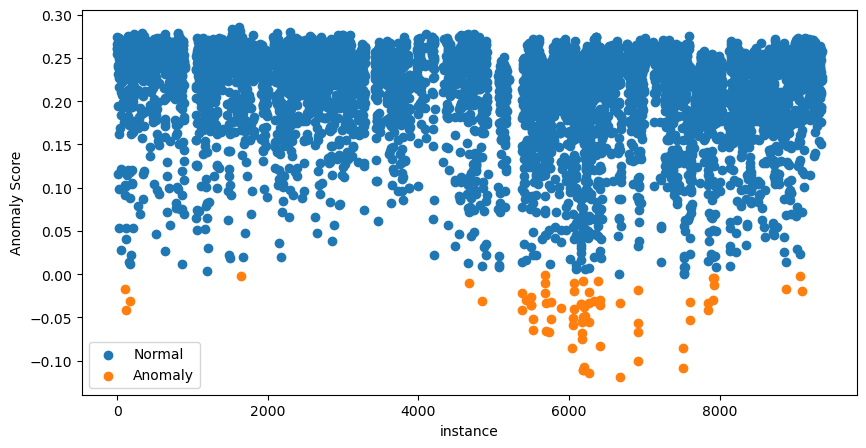

In [49]:
#visualization
plt.figure(figsize=(10,5))

# plot normal instances
normal = data[data['anomaly']==1]
plt.scatter(normal.index, normal['anomaly_score'], label='Normal')

# plot anomalies
anomalies= data[data['anomaly']== -1]
plt.scatter(anomalies.index, anomalies['anomaly_score'], label= 'Anomaly')

plt.xlabel("instance")
plt.ylabel("Anomaly Score")
plt.legend()
plt.show()

<h4>Further analysis</h4>
<p><b>Why?</b> Using above scatter plot we can identify potential anomalies. However, this does not tell us why these have been classifed as anomalies. Inoder to do that we will need to do further analysis</p>

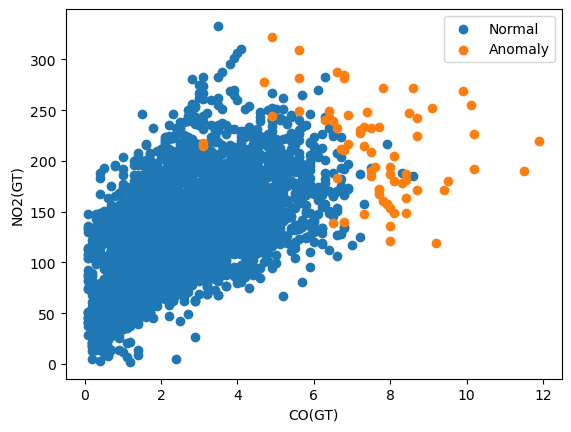

In [55]:
 # CO(GT) value v.s. their NO2(GT) value

# visualization
plt.figure(figure=(5,5))

#plot non-anomalies then anomalies
plt.scatter(normal['CO(GT)'], normal['NO2(GT)'], label='Normal')
plt.scatter(anomalies['CO(GT)'], anomalies['NO2(GT)'], label='Anomaly')
plt.xlabel("CO(GT)")
plt.ylabel("NO2(GT)")
plt.legend()
plt.show()